<a href="https://colab.research.google.com/github/JonasVerbickas/test-jupyter/blob/main/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import nltk
import re
import string
import unicodedata
import time
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from collections import UserDict
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
porter = nltk.PorterStemmer()

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
class StringWithDocId:
  def __init__(self, string, doc_id):
    self.string = string
    self.doc_id = doc_id
  
  def __lt__(token_with_doc_A, token_with_doc_B):
    if token_with_doc_A.string == token_with_doc_B.string:
      return token_with_doc_A.doc_id < token_with_doc_B.doc_id
    else:
      return token_with_doc_A.string < token_with_doc_B.string
    
  def __str__(self):
    return f"{self.string}: {self.doc_id}"

  def __repr__(self):
    return f"{self.string}: {self.doc_id}"

In [6]:
class StringWithDocIdAndPosition(StringWithDocId):
  def __init__(self, string, doc_id, position):
    super().__init__(string, doc_id)
    self.position = position
  
  def __lt__(token_with_doc_A, token_with_doc_B):
    if token_with_doc_A.string != token_with_doc_B.string:
      return token_with_doc_A.string < token_with_doc_B.string
    elif token_with_doc_A.doc_id != token_with_doc_B.doc_id:
      return token_with_doc_A.doc_id < token_with_doc_B.doc_id
    else:
      return token_with_doc_A.position < token_with_doc_B.position

In [7]:
class Posting(UserDict):
  def __init__(self):
    super().__init__()
    self.posting_dic = {}
    self.total_occurances = 0
  
  def __contains__(self, doc_id):
    return doc_id in self.posting_dic
  
  def __iter__(self):
      return iter(self.posting_dic.items())

  def __getitem__(self, doc_id):
      return self.posting_dic[doc_id]
    
  def get(self, k, default=None):
    return self[k]
  
  def __len__(self):
      return len(self.posting_dic)

  def add(self, doc_id, position):
    if doc_id in self.posting_dic:
      self.posting_dic[doc_id].append(position)
    else:
      self.posting_dic[doc_id] = [position]
    self.total_occurances += 1
  
  def __str__(self):
    return f"{self.total_occurances} total occurances: {[f'{len(positions)} in {doc_id}: {positions}' for doc_id, positions in self.posting_dic.items()]}"
  
  def __repr__(self):
    return str(self)

In [8]:
def wikipediaPreprocessing(text):
  text = unicodedata.normalize('NFKC', text)
  text = text.replace('\n', '')
  text = re.sub(r'\[.*?\]+', '', text)
  text = re.sub(r'Contents\s+1\s+Plot.+Plot', '', text) 
  text = re.sub(r'^.+From Wikipedia, the free encyclopedia.+List of episodes', '', text)
  return text

In [9]:
STOP_WORDS = nltk.corpus.stopwords.words('english')
class InvertedIndex:
    """
    Construct Inverted Index
    """
    def __init__(self):
        self.inverted_index = {}
        self.csv_terms = set()

    def __getitem__(self, key):
        return self.inverted_index[key]
      
    def keys(self):
      return self.inverted_index.keys()

    # def appendCSV(self, path):
    #   df = pd.read_csv(path)
    #   set_of_csv_entries = df['name']
    #   # for term in df['name']
    #   processed_csv_entries = self.processListOfTokens(set_of_csv_entries)
    #   # remove any duplicate entries
    #   print(processed_csv_entries[:10])
    #   without_duplicates = set(processed_csv_entries)
    #   self.csv_terms = self.csv_terms.union(without_duplicates)

    def read_data(self, path: str) -> list:
        """
        Read files from a directory and then append the data of each file into a list.
        """
        output = []
        for file in os.listdir(path):
          filename_with_path = os.path.join(path, file)
          if (file[-3:]).lower() == 'txt':
            with open(filename_with_path, 'r') as f:
              output.append(StringWithDocId(f.read(), file))
          # elif (file[-3:]).lower() == 'csv':
          #   self.appendCSV(filename_with_path)
          else:
            print(filename_with_path, "will be skipped")
        print(len(output))
        return output
      
    def processListOfTokens(self, tokenized):
      output = []
      for token in tokenized:
        token = token.lower()
        # 2. ignore stop-words
        if token in STOP_WORDS or token == 'the':
          continue
        # ignore tokens that have punctuation only
        if not re.search('\w', token):
          continue
        # 3. porter stemmer makes everything lowercase as well
        stemmed = porter.stem(token)
        output.append(stemmed)
      return output

    def process_document(self, document: str, wordpunct_tokenize=True) -> list:
        """
        pre-process a document and return a list of its terms
        str->list"""
        # 1. Wikipedia hyperlinks should be removed
        # 4. Use multi-word character/location names from .csv files
        text = wikipediaPreprocessing(document)
        if wordpunct_tokenize:
          tokenized  = nltk.tokenize.wordpunct_tokenize(text)
        else:
          tokenized  = nltk.tokenize.word_tokenize(text)
        # remove stop-words & apply stemming
        filtered_tokens = self.processListOfTokens(tokenized)
        return filtered_tokens
    
    def index_corpus(self, documents: list) -> None:
        """
        index given documents
        list->None"""
        starting_time = time.perf_counter()
        token_list = []
        # 1. Generate token sequence
        for doc in documents:
          curr_doc_id = doc.doc_id
          processed_string = self.process_document(doc.string)
          for i, token in enumerate(processed_string):
            token_with_doc_id_and_pos = StringWithDocIdAndPosition(token, curr_doc_id, i)
            token_list.append(token_with_doc_id_and_pos)
        # 2. Sort
        sorted_token_list = sorted(token_list)
        print("First 10 of sorted_token_list:", sorted_token_list[:10])
        # 3. Convert into dictionary of postings
        for token in sorted_token_list:
          if token.string not in self.inverted_index:
            self.inverted_index[token.string] = Posting()
          self.inverted_index[token.string].add(token.doc_id, token.position)
        # Print out some details about the dataset
        total_time_taken = round(time.perf_counter() - starting_time, 4)
        print(f"It took: {total_time_taken} seconds to index the whole corpus.")
        print(f"It has {len(self.inverted_index)} entries in total.")
      
    def dump(self, path: str) -> None:
        """
        provide a dump function to show index entries for a given set of terms        
        """
        if os.path.exists(path) == False:
          print("Path to file you provided doesn't exist")
          return
        with open(path, 'r') as f:
          file_contents = f.read()
          examples = file_contents.split('\n')
          for e in examples:
            processed_e = " ".join(self.process_document(e))
            try:
              print(self.inverted_index[processed_e])
            except KeyError:
              print(e, "was not found")
     
    def proximity_search(self, term1: str, term2: str, window_size: int = 3) -> dict:
        """
        1) check whether given two terms appear within a window
        2) calculate the number of their co-existance in a document
        3) add the document id and the number of matches into a dict
        return the dict"""
        term1 = self.processListOfTokens(self.process_document(term1))[0]
        term2 = self.processListOfTokens(self.process_document(term2))[0]
        print("Doc_ids containing the term1:", self.inverted_index[term1].keys())
        print("Doc_ids containing the term2:", self.inverted_index[term2].keys())
        documents_containing_both_terms = {}
        for term1_doc_id, term1_positions in self.inverted_index[term1]:
          # if both terms can be found in the same document
          if term1_doc_id in self.inverted_index[term2]:
            documents_containing_both_terms[term1_doc_id] = []
            for term1_position in term1_positions:
              print("- term1_position",term1_position)
              for term2_position in self.inverted_index[term2][term1_doc_id]:
                print("-- term2_position",term2_position)
                # abs doesn't work here for some weird reason (as in this evaluates as if abs function call didn't exist)
                if abs(term2_position - term1_position) < window_size:
                  documents_containing_both_terms[term1_doc_id].append((term1_position, term2_position))
                  print(f'Appended! abs({term2_position} - {term1_position})=', abs(term2_position - term1_position))
                # if term2 has passed the window of term1, move on to another term1 position
                elif term2_position - term1_position > window_size:
                  break
        return documents_containing_both_terms

In [10]:
def testReadData():
  index = InvertedIndex()
  corpus = index.read_data('/content/drive/MyDrive/Colab Notebooks/Simpsons2022')
  return (corpus[0]).string
testReadData()

/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_characters - row.csv will be skipped
/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_locations row.csv will be skipped
118


'Mr. Lisa Goes to Washington\nFrom Wikipedia, the free encyclopedia\n\n\n\nJump to navigation\nJump to search\n"Mr. Lisa Goes to Washington"\nThe Simpsons\xa0episode\nEpisode\xa0no.\nSeason\xa03\nEpisode 2\nDirected by\nWes Archer\nWritten by\nGeorge Meyer\nProduction code\n8F01\nOriginal air date\nSeptember 26, 1991[1]\n\nEpisode features\nChalkboard gag\n"Spitwads are not free speech"\nCouch gag\nThe family sits down and Homer pulls\xa0Santa\'s Little Helper\xa0from under him.\nCommentary\nMatt Groening\nAl Jean\nMike Reiss\nJulie Kavner\nWes Archer\nDavid Silverman\nEpisode chronology\n←\xa0Previous\n"Stark Raving Dad"\nNext\xa0→\n"When Flanders Failed"\nThe Simpsons\xa0(season 3)\nList of episodes\n"Mr. Lisa Goes to Washington" is the second episode of the\xa0third season\xa0of the American animated television series\xa0The Simpsons. It originally aired on the\xa0Fox network\xa0in the United States on September 26, 1991. In the episode,\xa0Lisa\xa0wins a patriotic essay contest abo

/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_characters - row.csv will be skipped
/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_locations row.csv will be skipped
118
Time taken 0.14935372800027835
['episod', 'lisa', 'simpson', 'washington', 'show', 'said', 'american', 'mr', 'goe', 'famili']


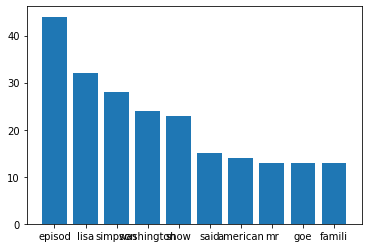

In [11]:
def testTokenzination():
    index = InvertedIndex() # initilaise the index
    corpus = index.read_data('/content/drive/MyDrive/Colab Notebooks/Simpsons2022') # specify the directory path in which files are located
    text = (corpus[0]).string
    start_time = time.perf_counter()
    tokenized = index.process_document(text)
    print("Time taken", time.perf_counter()-start_time)
    counter = Counter(tokenized).most_common(10)
    x = [x for x, _ in counter]
    print(x)
    y = [y for _, y in counter]
    plt.bar(x,y)
testTokenzination()

In [12]:
def testTokenzination():
    index = InvertedIndex() # initilaise the index
    corpus = index.read_data('/content/drive/MyDrive/Colab Notebooks/Simpsons2022') # specify the directory path in which files are located
    text = (corpus[0]).string
    start_time = time.perf_counter()
    tokenized = index.process_document(text, False)
    print("Time taken", time.perf_counter()-start_time)
    return tokenized
testTokenzination()[:60]

/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_characters - row.csv will be skipped
/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_locations row.csv will be skipped
118
Time taken 0.19947912400039058


['mr.',
 'lisa',
 'goe',
 'washington',
 'second',
 'episod',
 'third',
 'season',
 'american',
 'anim',
 'televis',
 'seri',
 'simpson',
 'origin',
 'air',
 'fox',
 'network',
 'unit',
 'state',
 'septemb',
 '26',
 '1991',
 'episod',
 'lisa',
 'win',
 'patriot',
 'essay',
 'contest',
 'unit',
 'state',
 'famili',
 'attend',
 'contest',
 'final',
 'washington',
 'd.c.',
 'dismay',
 'watch',
 'congressman',
 'accept',
 'bribe',
 'lisa',
 'lose',
 'contest',
 'pen',
 'scath',
 'screed',
 'condemn',
 'govern',
 'system',
 'corrupt',
 'congressman',
 'jail',
 'remov',
 'offic',
 'restor',
 'faith',
 'government.th',
 'episod',
 'written']

In [13]:
def main():
    "main call function"
    index = InvertedIndex() # initilaise the index
    corpus = index.read_data('/content/drive/MyDrive/Colab Notebooks/Simpsons2022') # specify the directory path in which files are located
    index.index_corpus(corpus) # index documents/corpus
    return index
index = main()

/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_characters - row.csv will be skipped
/content/drive/MyDrive/Colab Notebooks/Simpsons2022/simpsons_locations row.csv will be skipped
118
First 10 of sorted_token_list: [0: 4.2.txt, 0: 4.3.txt, 0: 4.4.txt, 0: 5.21.txt, 0: 5.21.txt, 0: 5.8.txt, 0: 5.8.txt, 0: 6.4.txt, 0: 7.3.txt, 0: 7.3.txt]
It took: 12.3659 seconds to index the whole corpus.
It has 9879 entries in total.


In [14]:
index.dump("/content/drive/MyDrive/Colab Notebooks/26957722.txt")

1172 total occurances: ['17 in 3.1.txt: [39, 203, 235, 285, 307, 312, 325, 339, 489, 499, 764, 767, 994, 1016, 1121, 1665, 1698]', '4 in 3.10.txt: [850, 1016, 1142, 1223]', '4 in 3.11.txt: [336, 527, 622, 651]', '12 in 3.12.txt: [34, 40, 106, 133, 140, 178, 183, 389, 392, 410, 466, 567]', '28 in 3.13.txt: [1, 21, 45, 56, 89, 127, 130, 140, 165, 212, 224, 230, 242, 248, 272, 285, 301, 537, 615, 637, 696, 734, 810, 814, 846, 863, 1023, 1033]', '2 in 3.14.txt: [296, 316]', '9 in 3.15.txt: [38, 66, 214, 240, 327, 459, 484, 498, 642]', '27 in 3.16.txt: [0, 21, 34, 69, 100, 161, 175, 188, 217, 237, 253, 266, 277, 286, 334, 415, 427, 435, 542, 562, 623, 645, 736, 837, 893, 911, 969]', '1 in 3.17.txt: [906]', '22 in 3.18.txt: [42, 75, 154, 175, 183, 214, 218, 231, 303, 312, 351, 392, 533, 560, 589, 608, 743, 779, 849, 874, 885, 899]', '9 in 3.19.txt: [63, 155, 180, 264, 281, 291, 677, 692, 1166]', '3 in 3.2.txt: [203, 456, 707]', '3 in 3.20.txt: [182, 843, 1563]', '17 in 3.21.txt: [44, 50, 56,

In [15]:
index.proximity_search('award', 'winning', 100)

Doc_ids containing the term1: KeysView(93 total occurances: ['1 in 3.1.txt: [1259]', '1 in 3.12.txt: [770]', '2 in 3.13.txt: [109, 724]', '3 in 3.14.txt: [727, 770, 809]', '4 in 3.21.txt: [363, 364, 380, 616]', '8 in 3.24.txt: [41, 164, 168, 189, 577, 634, 639, 854]', '5 in 3.6.txt: [137, 698, 729, 743, 752]', '2 in 3.7.txt: [209, 1313]', '1 in 3.8.txt: [733]', '1 in 4.10.txt: [463]', '8 in 4.19.txt: [149, 163, 182, 189, 210, 230, 643, 686]', '1 in 4.2.txt: [1223]', '3 in 4.20.txt: [95, 585, 587]', '1 in 4.22.txt: [602]', '3 in 4.9.txt: [62, 967, 990]', '4 in 5.1.txt: [288, 323, 773, 1229]', '1 in 5.13.txt: [843]', '2 in 5.15.txt: [122, 139]', '5 in 5.17.txt: [26, 766, 772, 786, 793]', '2 in 5.3.txt: [1988, 2121]', '1 in 5.9.txt: [340]', '2 in 6.12.txt: [83, 574]', '1 in 6.16.txt: [796]', '1 in 6.18.txt: [371]', '3 in 6.19.txt: [50, 60, 603]', '1 in 6.2.txt: [171]', '2 in 6.22.txt: [969, 979]', '2 in 6.25.txt: [1988, 2121]', '1 in 6.6.txt: [1500]', '1 in 6.7.txt: [422]', '2 in 7.1.txt:

{'3.13.txt': [(724, 753), (724, 771)],
 '3.14.txt': [(727, 712), (770, 712), (809, 712)],
 '3.21.txt': [(363, 361),
  (363, 378),
  (364, 361),
  (364, 378),
  (380, 361),
  (380, 378),
  (616, 613)],
 '3.6.txt': [(698, 742),
  (698, 751),
  (729, 742),
  (729, 751),
  (743, 742),
  (743, 751),
  (752, 742),
  (752, 751)],
 '3.8.txt': [],
 '4.10.txt': [(463, 464)],
 '4.19.txt': [(149, 207),
  (149, 232),
  (163, 207),
  (163, 232),
  (182, 207),
  (182, 232),
  (189, 207),
  (189, 232),
  (210, 207),
  (210, 232),
  (230, 207),
  (230, 232)],
 '4.2.txt': [(1223, 1235)],
 '4.9.txt': [(967, 1002), (990, 1002)],
 '5.1.txt': [(288, 286), (323, 286)],
 '5.15.txt': [(122, 119), (139, 119)],
 '5.17.txt': [(26, 23)],
 '5.9.txt': [(340, 341)],
 '6.18.txt': [],
 '6.19.txt': [(50, 59), (60, 59), (603, 612)],
 '6.2.txt': [(171, 145), (171, 220)],
 '6.22.txt': [(969, 978), (979, 978)],
 '6.7.txt': [(422, 423)],
 '7.12.txt': [(547, 529), (556, 529), (570, 529)],
 '7.5.txt': [],
 '7.6.txt': [(1529, 1